In [ ]:
import zipfile

with zipfile.ZipFile("archive (2).zip", "r") as zip_ref:
    zip_ref.extractall("dataset")  # Extract to 'dataset' folder


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D ,Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Preparing data using DataGenerator

In [ ]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
EPOCHS = 50
lr = 0.0001   # learning rate

# Define paths
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/test"

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

val_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
train_num = train_generator.samples
valid_num = val_generator.samples

# Creating Model

In [ ]:
# using tranfer learning model "VGG16"
mobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in mobileNetV2_base.layers:
    layer.trainable = False

# Build model
model = Sequential([
    mobileNetV2_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Adjust to number of classes
])

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stoppings and model checkpoints

In [ ]:
# Callbacks for Early Stopping and Saving Best Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3,verbose=1 ,restore_best_weights=True),
    ModelCheckpoint('best_E2motionDetection_model.keras', monitor='val_loss',verbose=1, save_best_only=True)
]


In [ ]:
#fitting images to CNN
history = model.fit(train_generator,
                         steps_per_epoch=train_num//BATCH_SIZE,
                         validation_data=val_generator,
                         epochs=EPOCHS,
                         validation_steps=valid_num//BATCH_SIZE,
                         callbacks=callbacks
                         )

Epoch 1/50
  4/224 ━━━━━━━━━━━━━━━━━━━━ 24:24 7s/step - accuracy: 0.1969 - loss: 2.2413

KeyboardInterrupt: 

In [ ]:

# Loading the best fit model
from keras.models import load_model
model = load_model("/content/best_E2motionDetection_model.keras")

In [ ]:
h =  history.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

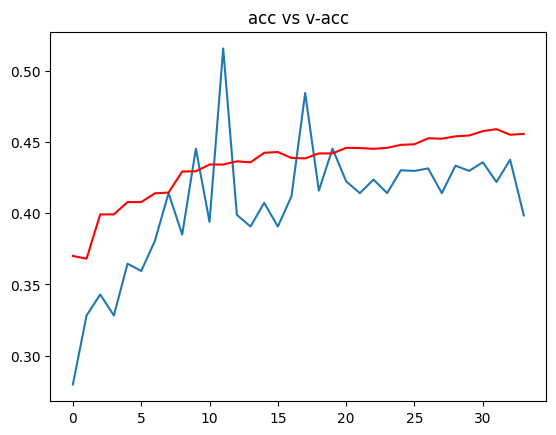

In [ ]:

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

In [ ]:

plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# just to map o/p values
op = dict(zip( train_generator.class_indices.values(), train_generator.class_indices.keys()))

# Testing of Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
 the image is of surprise


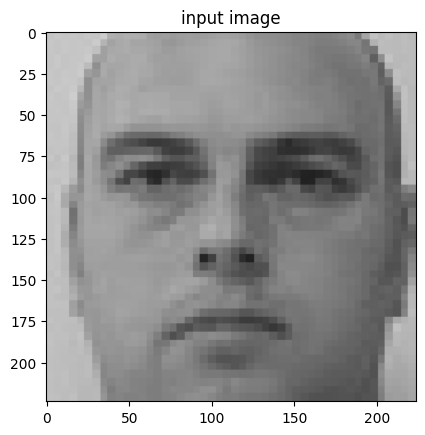

In [ ]:

# path for the image to see if it predics correct class

path = "/content/dataset/test/neutral/PrivateTest_11752870.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()